<a href="https://colab.research.google.com/github/FatmaBuseBorlu/DRAMER-Dataset/blob/main/B%C4%B0LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Veri setinin bulunduğu dizin
dataset_path = "/content/drive/MyDrive/Dramer/Kodlar/DREAMER.mat"

In [ ]:
class AddNoise:
    """EEG sinyallerine rastgele gürültü ekler."""
    def __init__(self, noise_level=0.05):
        self.noise_level = noise_level

    def __call__(self, eeg=None, **kwargs):
        if eeg is not None:
            noise = torch.randn_like(eeg) * self.noise_level
            eeg = eeg + noise
        return {**kwargs, 'eeg': eeg}

# BiLSTM Modeli Tanımı
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2, num_classes=2, dropout_rate=0.3):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_valence = nn.Linear(hidden_size * 2, num_classes)  # Bidirectional olduğu için *2
        self.fc_arousal = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Bidirectional için *2
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Son zaman adımını al
        out = self.dropout(out)
        valence_output = self.fc_valence(out)
        arousal_output = self.fc_arousal(out)
        return valence_output, arousal_output

# Veri Seti Hazırlığı
offline_transform = transforms.Compose([
    transforms.BaselineRemoval(),
    transforms.MeanStdNormalize(),
    transforms.To2d(),
    transforms.ToTensor(),
    transforms.RandomNoise(std=0.02),
    transforms.RandomFlip()
])

dataset = DREAMERDataset(
    io_path='./dreamer_bilstm_data33',
    mat_path='/content/drive/MyDrive/Dramer/Kodlar/DREAMER.mat',  # Veri seti yolunu buraya ekleyin
    offline_transform=offline_transform,
    label_transform=transforms.Compose([
        transforms.Select(['valence', 'arousal']),
        transforms.Binary(3.0)  # Valence ve Arousal için binary sınıflandırma
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    verbose=False
)

[2024-12-27 16:20:11] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./dreamer_bilstm_data33.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from ./dreamer_bilstm_data33.


In [ ]:
# Veri Setini Eğitim ve Test Olarak Böl
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
# Veri yükleyiciler
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Model Tanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

valence_criterion = nn.CrossEntropyLoss()
arousal_criterion = nn.CrossEntropyLoss()

# Valence ve Arousal için ağırlıklar
valence_weight = 0.6 # Valence kaybına verilen önem
arousal_weight = 0.4  # Arousal kaybına verilen önem

def train_epoch():
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.float().to(device).squeeze(1)
        labels = torch.stack(labels, dim=1).long().to(device)
        optimizer.zero_grad()
        valence_output, arousal_output = model(inputs)
        loss_valence = valence_criterion(valence_output, labels[:, 0])
        loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
        loss = valence_weight * loss_valence + arousal_weight * loss_arousal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test_model():
    model.eval()
    running_loss = 0.0
    valence_preds, arousal_preds, all_labels = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device).squeeze(1)
            labels = torch.stack(labels, dim=1).long().to(device)
            valence_output, arousal_output = model(inputs)
            loss_valence = valence_criterion(valence_output, labels[:, 0])
            loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
            loss = valence_weight * loss_valence + arousal_weight * loss_arousal
            running_loss += loss.item()
            _, valence_pred = torch.max(valence_output, 1)
            _, arousal_pred = torch.max(arousal_output, 1)
            valence_preds.extend(valence_pred.cpu().numpy())
            arousal_preds.extend(arousal_pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valence_acc = accuracy_score([l[0] for l in all_labels], valence_preds)
    arousal_acc = accuracy_score([l[1] for l in all_labels], arousal_preds)
    valence_f1 = f1_score([l[0] for l in all_labels], valence_preds, average='weighted')
    arousal_f1 = f1_score([l[1] for l in all_labels], arousal_preds, average='weighted')

    return running_loss / len(test_loader), valence_acc, arousal_acc, valence_f1, arousal_f1, all_labels, valence_preds, arousal_preds # Corrected indentation

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Early Stopping
early_stop_patience = 5
# Eğitim Döngüsü
epochs = 10
train_losses, test_losses = [], []
best_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    train_loss = train_epoch()
    test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, _, _, _ = test_model()
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Scheduler'ı test kaybına göre adım attırın
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Valence Accuracy: {valence_acc:.4f}, Arousal Accuracy: {arousal_acc:.4f}")
    print(f"Valence F1 Score: {valence_f1:.4f}, Arousal F1 Score: {arousal_f1:.4f}")

    # Early Stopping kontrolü
    if test_loss < best_loss:
        best_loss = test_loss
        early_stop_counter = 0
        print(f"Epoch {epoch+1}: Test Loss improved to {test_loss:.4f}.")
    else:
        early_stop_counter += 1
        print(f"Epoch {epoch+1}: No improvement in Test Loss. Early stop counter: {early_stop_counter}/{early_stop_patience}.")

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered! Stopping training.")
        break

Epoch 1/10, Train Loss: 0.6216, Test Loss: 0.6059
Valence Accuracy: 0.6161, Arousal Accuracy: 0.7741
Valence F1 Score: 0.4753, Arousal F1 Score: 0.6799
Epoch 1: Test Loss improved to 0.6059.
Epoch 2/10, Train Loss: 0.6062, Test Loss: 0.6000
Valence Accuracy: 0.6198, Arousal Accuracy: 0.7743
Valence F1 Score: 0.5035, Arousal F1 Score: 0.6803
Epoch 2: Test Loss improved to 0.6000.
Epoch 3/10, Train Loss: 0.5987, Test Loss: 0.5934
Valence Accuracy: 0.6251, Arousal Accuracy: 0.7743
Valence F1 Score: 0.5320, Arousal F1 Score: 0.6803
Epoch 3: Test Loss improved to 0.5934.
Epoch 4/10, Train Loss: 0.5894, Test Loss: 0.5871
Valence Accuracy: 0.6319, Arousal Accuracy: 0.7744
Valence F1 Score: 0.5644, Arousal F1 Score: 0.6808
Epoch 4: Test Loss improved to 0.5871.
Epoch 5/10, Train Loss: 0.5795, Test Loss: 0.5819
Valence Accuracy: 0.6358, Arousal Accuracy: 0.7758
Valence F1 Score: 0.5985, Arousal F1 Score: 0.6854
Epoch 5: Test Loss improved to 0.5819.
Epoch 6/10, Train Loss: 0.5706, Test Loss: 0.

Final Test Loss: 0.5731
Final Valence Accuracy: 0.6496, Final Arousal Accuracy: 0.7833
Final Valence F1 Score: 0.6287, Final Arousal F1 Score: 0.7102
Confusion Matrix (Valence):
 [[2437 4217]
 [1792 8703]]
Confusion Matrix (Arousal):
 [[  347  3603]
 [  113 13086]]


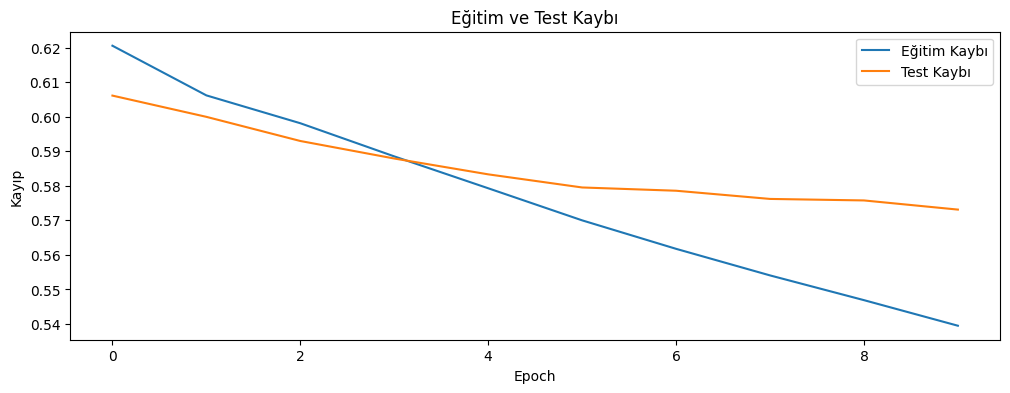

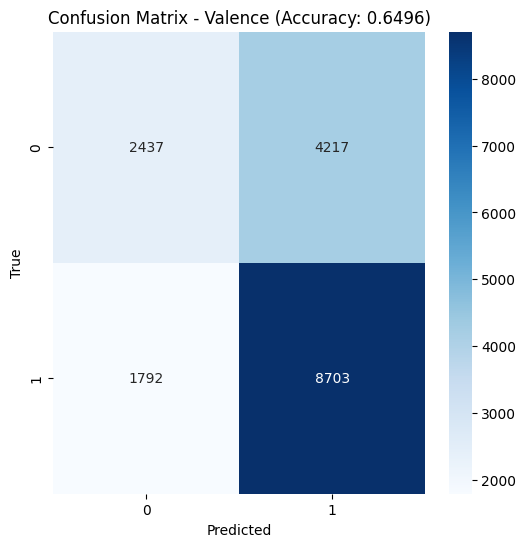

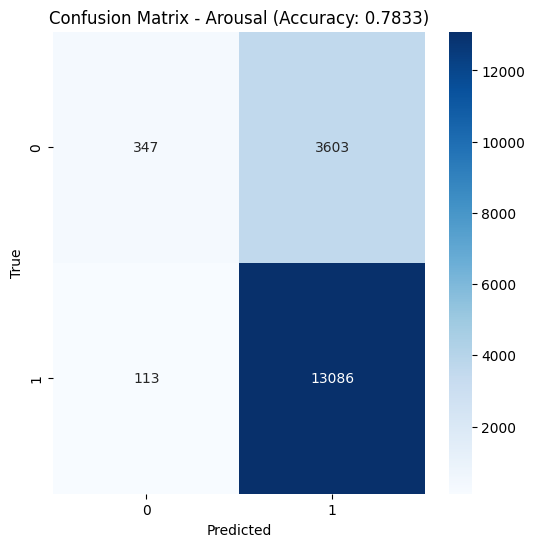

In [ ]:
# Sonuçları Test Et ve Raporla
test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, all_labels, valence_preds, arousal_preds = test_model()
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Valence Accuracy: {valence_acc:.4f}, Final Arousal Accuracy: {arousal_acc:.4f}")
print(f"Final Valence F1 Score: {valence_f1:.4f}, Final Arousal F1 Score: {arousal_f1:.4f}")

# Karışıklık Matrisleri
cm_valence = confusion_matrix([l[0] for l in all_labels], valence_preds)
cm_arousal = confusion_matrix([l[1] for l in all_labels], arousal_preds)
print("Confusion Matrix (Valence):\n", cm_valence)
print("Confusion Matrix (Arousal):\n", cm_arousal)

# Görselleştirme Fonksiyonu
def plot_results(train_losses, test_losses, cm_valence, cm_arousal, valence_acc, arousal_acc):
    # Eğitim ve Test Kaybı Grafiği
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    # Valence Karışıklık Matrisi
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_valence, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Valence (Accuracy: {valence_acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Arousal Karışıklık Matrisi
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_arousal, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Arousal (Accuracy: {arousal_acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_results(train_losses, test_losses, cm_valence, cm_arousal, valence_acc, arousal_acc)
